In [9]:
%run /home/grg/git/alfa/nilearn-helper.py
%matplotlib inline
from glob import glob
import os.path as osp
from nistats import thresholding
import numpy as np
from nilearn import image, plotting
import nibabel as nib
import json
import os

# Kind recipe to extract clusters from thresholded SPMt maps and make them as a map of ROIs

### First threshold your SPMt map

In [4]:
original_fp = '/home/grg/spm/analyses/analysis_20170228/MD_DARTEL_csf5_interaction_linearage/estimatecontrasts/spmT_0028.nii'
thresholded_map, threshold = thresholding.map_threshold(original_fp, threshold=1e-3)
thresholded_fp = '/tmp/thresholded_map.nii.gz'
thresholded_map.to_filename(thresholded_fp)  # Save it on disk

### Define a folder containing rough hand-drawn ROIs over the clusters
The given names are very approximative with respect to the rough location of the cluster.

In [7]:

roi_dir = '/home/grg/spm/ROIapoE/ROI_DARTEL/csf5/'
rois_fp = [e for e in glob(osp.join(roi_dir, '*.nii.gz')) if not '_cleaned' in e and not 'rois' in e]
print rois_fp
print len(rois_fp), 'files found.'

['/home/grg/spm/ROIapoE/ROI_DARTEL/csf5/left_perivent.nii.gz', '/home/grg/spm/ROIapoE/ROI_DARTEL/csf5/left_insula.nii.gz', '/home/grg/spm/ROIapoE/ROI_DARTEL/csf5/left_occip2.nii.gz', '/home/grg/spm/ROIapoE/ROI_DARTEL/csf5/left_temporal.nii.gz', '/home/grg/spm/ROIapoE/ROI_DARTEL/csf5/coronaradiata.nii.gz', '/home/grg/spm/ROIapoE/ROI_DARTEL/csf5/left_temporal2.nii.gz', '/home/grg/spm/ROIapoE/ROI_DARTEL/csf5/right.nii.gz', '/home/grg/spm/ROIapoE/ROI_DARTEL/csf5/right_perivent.nii.gz', '/home/grg/spm/ROIapoE/ROI_DARTEL/csf5/left_occip.nii.gz', '/home/grg/spm/ROIapoE/ROI_DARTEL/csf5/right_temporal.nii.gz']
10 files found.


### Take each hand-drawn ROI and generate a cleaned version of it using the intersection with the thresholded map

/tmp/roi/left_temporal.nii.gz


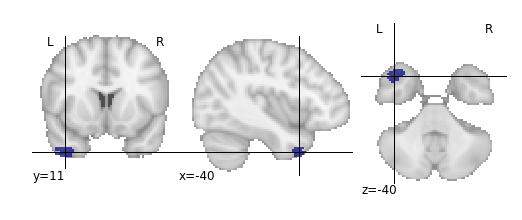

In [25]:
thresholded_img = np.asarray(nib.load(thresholded_fp).dataobj)

for roi_fp in rois_fp:
    print roi_fp
    roi = np.array(image.load_img(roi_fp).dataobj)
    roi[thresholded_img==0] = 0
    img = image.new_img_like(roi_fp, roi)
    plotting.plot_roi(img)
    img.to_filename(osp.splitext(roi_fp)[0] + '_cleaned.nii.gz')

### Collect all the cleaned ROIs in a single Nifti

['/home/grg/spm/ROIapoE/ROI_DARTEL/csf5/left_occip.nii_cleaned.nii.gz', '/home/grg/spm/ROIapoE/ROI_DARTEL/csf5/left_temporal.nii_cleaned.nii.gz', '/home/grg/spm/ROIapoE/ROI_DARTEL/csf5/left_temporal2_cleaned.nii.gz', '/home/grg/spm/ROIapoE/ROI_DARTEL/csf5/right_perivent.nii_cleaned.nii.gz', '/home/grg/spm/ROIapoE/ROI_DARTEL/csf5/left_occip2.nii_cleaned.nii.gz', '/home/grg/spm/ROIapoE/ROI_DARTEL/csf5/left_perivent.nii_cleaned.nii.gz', '/home/grg/spm/ROIapoE/ROI_DARTEL/csf5/coronaradiata.nii_cleaned.nii.gz', '/home/grg/spm/ROIapoE/ROI_DARTEL/csf5/right.nii_cleaned.nii.gz', '/home/grg/spm/ROIapoE/ROI_DARTEL/csf5/right_temporal.nii_cleaned.nii.gz', '/home/grg/spm/ROIapoE/ROI_DARTEL/csf5/left_insula.nii_cleaned.nii.gz']
10 cleaned ROIs found


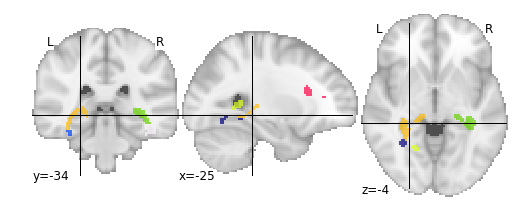

In [10]:
rois_fp = '/tmp/rois2.nii.gz' # File where the ROIs will be collected
roi_fps = glob(osp.join(roi_dir, '*_cleaned.nii.gz'))
print roi_fps
print len(roi_fps), 'cleaned ROIs found'

img = np.asarray(image.load_img(roi_fps[0]).dataobj)
for i in range(1, len(roi_fps)):
    new_img = np.asarray(image.load_img(roi_fps[i]).dataobj)
    img[new_img!=0] = i+1
    
finalimg = image.new_img_like(roi_fps[0], img)
finalimg.to_filename(rois_fp)
plotting.plot_roi(finalimg)

### Compile values from create ROI

In [ ]:
roivalues_wd = '/tmp/roivalues_csf.5' # Folder where the files containing the ROI values will be stored
data_wd = '/home/grg/dartel_csf.5/' # Folder containing the images over which the ROI values will be extracted

subjects = json.load(open(osp.join('/home/grg/spm', 'data', 'subjects.json'))) # List of subjects

# Load the collection of ROIs
rois = np.asarray(nib.load(rois_fp).dataobj)
nb_roi = len(np.unique(rois)) - 1
print nb_roi, 'regions - ', len(subjects), 'subjects'

# Iterate over subjects
for s in subjects:
    try:
        mdfp = glob(osp.join(data_wd, 'rswr%s*.nii'%s))[0]
        # Build the command and run it
        cmd = 'AimsRoiFeatures -i %s -s %s -o %s'%(rois_fp, mdfp, osp.join(roivalues_wd, '%s_stats.csv'%s))
        print cmd
        os.system(cmd)
    except Exception as e:
        print s, e

10 regions
AimsRoiFeatures -i /tmp/rois2.nii.gz -s /home/grg/dartel_csf.5/rswr10070_MD_t1space_wo_csf_nohdr.nii -o /tmp/roivalues_csf.5/10070_stats.csv
AimsRoiFeatures -i /tmp/rois2.nii.gz -s /home/grg/dartel_csf.5/rswr10102_MD_t1space_wo_csf_nohdr.nii -o /tmp/roivalues_csf.5/10102_stats.csv
AimsRoiFeatures -i /tmp/rois2.nii.gz -s /home/grg/dartel_csf.5/rswr10108_MD_t1space_wo_csf_nohdr.nii -o /tmp/roivalues_csf.5/10108_stats.csv
AimsRoiFeatures -i /tmp/rois2.nii.gz -s /home/grg/dartel_csf.5/rswr10235_MD_t1space_wo_csf_nohdr.nii -o /tmp/roivalues_csf.5/10235_stats.csv
